```
This software is part of GPU Ocean. 

Copyright (C) 2018 SINTEF Digital
Copyright (C) 2018 Norwegian Meteorological Institute

This notebook implements the experiments to evaluate convergence rates
for the four numerical schemes, as reported in Section 4.7 in Test Cases for 
Rotational Shallow-Water Schemes by Holm, Brodtkorb, Broström, Christensen 
and Sætra. 

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Numerical Order

This notebook runs an experiment to evaluate the numerical order for each of the four schemes. By running this notebook, the convergence plots presented in Section 4.7 "Numerical Order" in the paper should be reproduced.



## Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import os
import datetime
import gc
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(6.0, 4.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import FBL, CTCS,KP07, CDKLM16, PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
%setup_logging compareschemes2d.log
%cuda_context_handler gpu_ctx

Registering logging to compareschemes2d.log
Python version 3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
PyCUDA version 2017.1.1
CUDA version (9, 1, 0)
Driver version 9010
Using 'GeForce 840M' GPU
Created context handle <584278418192>


In [3]:
#Create output directory for images
imgdir='images_convergence_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print("Saving images to " + imgdir)

Saving images to images_convergence_2018_09_03-16_19_34


In [4]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       #cycler('markersize', [15, 15, 15, 15, 15, 15]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k']) )

In [5]:
width = 100
height = 100

domain_min = 16
    
g = 9.81
r = 0.0
#f = 8.0e-5
f = 0.0

end_time = 1

In [6]:
def average(highres_solution, factor):
    NX = highres_solution.shape[1]
    NY = highres_solution.shape[0]
    
    assert(NY % factor == 0)
    assert(NX % factor == 0)
    
    nx = int(NX / factor)
    ny = int(NY / factor)
    
    factor = int(factor)
    
    return  highres_solution.reshape([ny, factor, nx, factor]).mean(3).mean(1)

Finite volume
FV: Max=0.00093, min=0.00000, sum=0.0000840759
FV: Max=0.00098, min=0.00000, sum=0.0000840759
FV: Max=0.00100, min=0.00000, sum=0.0000840759
FV: Max=0.00100, min=0.00000, sum=0.0000840759
FV: Max=0.00100, min=0.00000, sum=0.0000840759
Finite difference
FD: Max=0.01000, min=0.00000, sum=0.0007320320
FD: Max=0.01000, min=0.00000, sum=0.0007837343
FD: Max=0.01000, min=0.00000, sum=0.0008115245
FD: Max=0.01000, min=0.00000, sum=0.0008259438
FD: Max=0.01000, min=0.00000, sum=0.0008333020


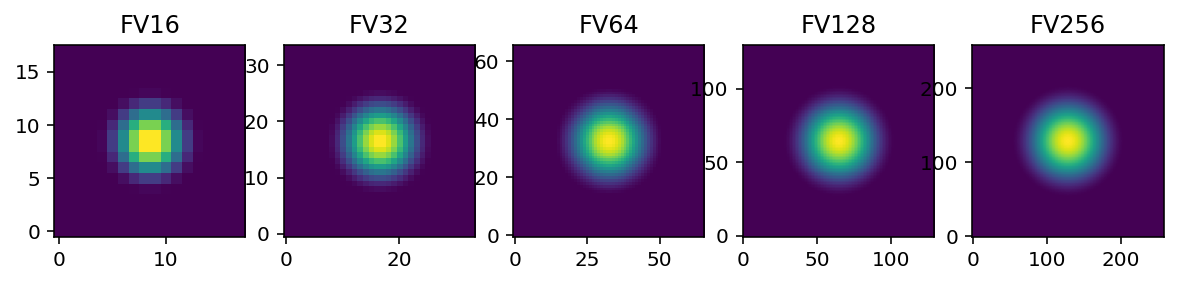

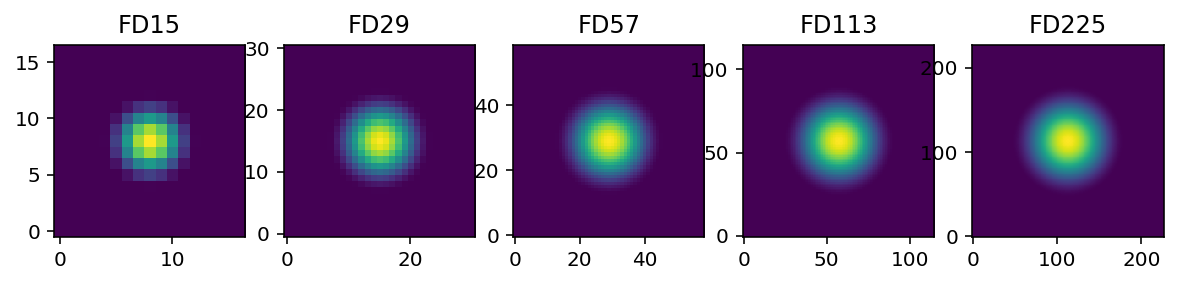

In [7]:
def initH(h0, ghosts):    
    waterHeight = 0.5
    h0.fill(waterHeight)
    
def initEtaFV(eta0, ghosts, reference_domain_size):
    ref_nx = reference_domain_size
    ref_ny = reference_domain_size
    nx = eta0.shape[1] - ghosts[0] - ghosts[2]
    ny = eta0.shape[0] - ghosts[1] - ghosts[3]
    
    def my_cos(i, j):
        size = 0.6
        x = 2*(i + 0.5 - ref_nx/2.0) / float(ref_nx)
        y = 2*(j + 0.5 - ref_ny/2.0) / float(ref_ny)
        r = np.sqrt(x**2 + y**2)
        return 0.05*(1.0 + np.cos(np.pi*r/size)) * (r < size)
    
    #Generate disturbance 
    disturbance = np.fromfunction(lambda i, j: my_cos(i,j), (ref_ny, ref_nx))
    disturbance = average(disturbance, ref_nx/nx) 
    
    eta0.fill(0.0)
    x0, x1 = ghosts[0], nx+ghosts[0]
    y0, y1 = ghosts[1], ny+ghosts[1]
    eta0[y0:y1, x0:x1] += (0.01*disturbance)
    

def initEtaFD(eta0, ghosts):
    nx = eta0.shape[1] - ghosts[0] - ghosts[2]
    ny = eta0.shape[0] - ghosts[1] - ghosts[3]
    
    def my_cos(i, j):
        size = 0.6
        x = 2*(i - (nx-1)/2.0) / float(nx-1)
        y = 2*(j - (ny-1)/2.0) / float(ny-1)
        r = np.sqrt(x**2 + y**2)
        return 0.5*(1.0 + np.cos(np.pi*r/size)) * (r < size)
    
    #Generate disturbance 
    disturbance = np.fromfunction(lambda i, j: my_cos(i,j), (ny, nx))
    
    eta0.fill(0.0)
    x0, x1 = ghosts[0], nx+ghosts[0]
    y0, y1 = ghosts[1], ny+ghosts[1]
    eta0[y0:y1, x0:x1] += (0.01*disturbance)
    
    
def initHU(hu0, ghosts):
    hu0.fill(0.0)
    
def initHV(hv0, ghosts):
    hv0.fill(0.0)

def testInitDataFV(domain_size, reference_domain_size):
    
    nx = domain_size
    ny = domain_size
    
    ghosts = [1, 1, 1, 1] 
    dataShape = (ny + ghosts[1]+ghosts[3], 
                 nx + ghosts[0]+ghosts[2])

    eta0 = np.zeros(dataShape, dtype=np.float32);
    
    initEtaFV(eta0, ghosts, reference_domain_size)
    
    return eta0#[ghosts[1]:eta0.shape[1]+ghosts[1], ghosts[0]:eta0.shape[0]+ghosts[0]]

def testInitDataFD(domain_size):
    nx = domain_size
    ny = domain_size
    
    ghosts = [1, 1, 1, 1] 
    dataShape = (ny + ghosts[1]+ghosts[3], 
                 nx + ghosts[0]+ghosts[2])

    eta0 = np.zeros(dataShape, dtype=np.float32);
    
    initEtaFD(eta0, ghosts)
    
    return eta0#[ghosts[1]:eta0.shape[1]+ghosts[1], ghosts[0]:eta0.shape[0]+ghosts[0]]
    
plt.figure(figsize=(12,8))
print("Finite volume")
for i in range(5):
    domain_size = domain_min*2**i
    eta0 = testInitDataFV(domain_size, domain_min*2**6)
    plt.subplot(1, 6, i+1)
    plt.imshow(eta0, interpolation='nearest', origin='lower')
    plt.title("FV"+str(domain_size))
    print("FV: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(eta0), np.min(eta0), np.sum(eta0/(domain_size*domain_size))))
    
plt.figure(figsize=(12,8))
print("Finite difference")
domain_size = int(domain_min/2)
for i in range(5):
    domain_size = domain_size*2-1
    eta0 = testInitDataFD(domain_size)
    plt.subplot(1, 6, i+1)
    plt.imshow(eta0, interpolation='nearest', origin='lower')
    plt.title("FD"+str(domain_size))
    print("FD: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(eta0), np.min(eta0), np.sum(eta0/(domain_size*domain_size))))

In [8]:
def plotData(eta0, u0, v0, eta1, u1, v1):
    fig, axarr = plt.subplots(2, 3, figsize=(12, 8))
    axarr[0, 0].imshow(eta0, interpolation="nearest")
    axarr[0, 1].imshow(u0, interpolation="nearest")
    axarr[0, 2].imshow(v0, interpolation="nearest")
    axarr[1, 0].imshow(eta1, interpolation="nearest")
    axarr[1, 1].imshow(u1, interpolation="nearest")
    axarr[1, 2].imshow(v1, interpolation="nearest")
    print("Eta0: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta0), np.min(eta0)))
    print("Eta1: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta1), np.min(eta1)))

## Forward Backward Linear

In [9]:
def benchmarkFBL(fbl_filename):
    def runFBL(domain_size):
        #Clean up old simulator if any:
        if 'fbl_sim' in globals():
            fbl_sim.cleanUp()

        nx = domain_size
        ny = domain_size

        dx = float(width/(nx-1))
        dy = float(height/(ny-1))

        ghosts = [0, 0, 0, 0]
        dataShape = (ny + ghosts[1]+ghosts[3], 
                     nx + ghosts[0]+ghosts[2])

        h0 = np.zeros(dataShape, dtype=np.float32);
        eta0 = np.zeros(dataShape, dtype=np.float32);
        hu0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32);
        hv0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32);
        
        max_h_estimate = 0.6
        max_u_estimate = 0.1*np.sqrt(2.0)
        dt = 0.45 * min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))

        initH(h0, ghosts)
        initEtaFD(eta0, ghosts)
        initHU(hu0, ghosts)
        initHV(hv0, ghosts)

        #Initialize simulator
        fbl_sim = FBL.FBL(gpu_ctx, \
                      h0, eta0, hu0, hv0, \
                      nx, ny, \
                      dx, dy, dt, \
                      g, f, r)

        t = fbl_sim.step(end_time)
        eta1, hu1, hv1 = fbl_sim.download()
        print("Domain size={:d}, dt={:f}, nt={}, eta=[{:f}, {:f}]".format(domain_size, dt, fbl_sim.num_iterations, np.min(eta1), np.max(eta1)))

        return [eta0, hu0, hv0, eta1, hu1, hv1]

    #Run all domain sizes 
    data = {};
    domain_size = int((domain_min)/2)
    for i in range(9):
        domain_size = domain_size*2-1
        [_, _, _, eta1, _, _] = runFBL(domain_size)
        data[str(domain_size)] = eta1

    #Save to file
    np.savez_compressed(fbl_filename, **data)
    
fbl_filename = imgdir + "/FBL_data.npz"
benchmarkFBL(fbl_filename)

Domain size=15, dt=1.251898, nt=1, eta=[0.000000, 0.009487]
Domain size=29, dt=0.625949, nt=2, eta=[0.000000, 0.009595]
Domain size=57, dt=0.312975, nt=4, eta=[0.000000, 0.009654]
Domain size=113, dt=0.156487, nt=7, eta=[0.000000, 0.009693]
Domain size=225, dt=0.078244, nt=13, eta=[0.000000, 0.009712]
Domain size=449, dt=0.039122, nt=26, eta=[0.000000, 0.009722]
Domain size=897, dt=0.019561, nt=52, eta=[0.000000, 0.009727]
Domain size=1793, dt=0.009780, nt=103, eta=[0.000000, 0.009730]
Domain size=3585, dt=0.004890, nt=205, eta=[0.000000, 0.009731]


2.1977191623187132e-05
1.3108035370569746e-05
7.749086198907466e-06
3.946347897537504e-06
1.9789019213160783e-06
9.318131975740578e-07
4.037979930877688e-07
1.3478613226520266e-07


(11.809100198112247,
 2277.4808875192102,
 1.0447896509106243e-07,
 2.8352316223258705e-05)

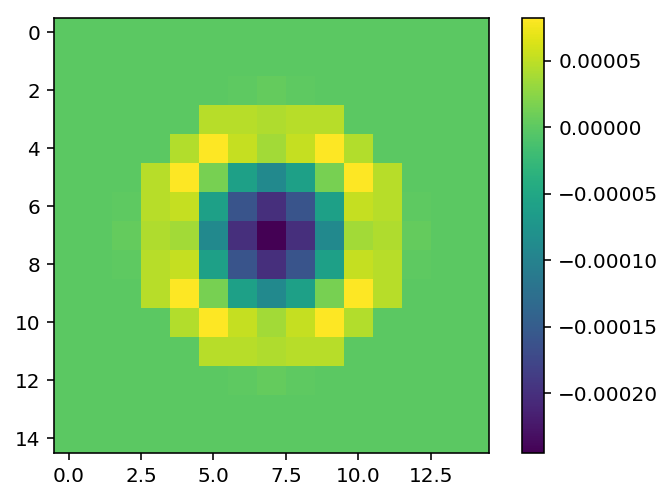

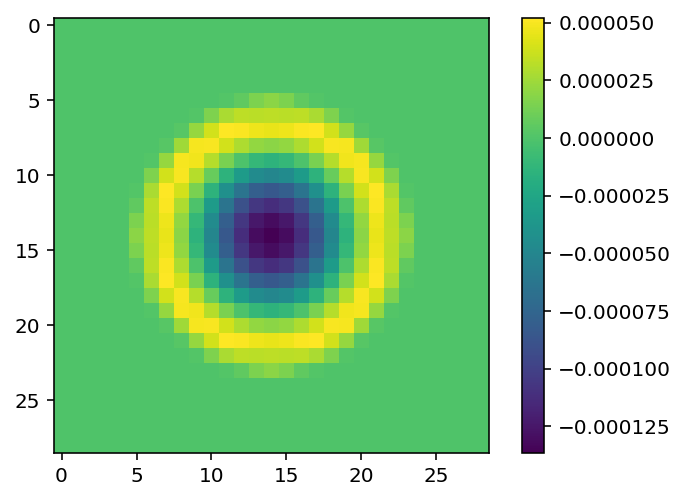

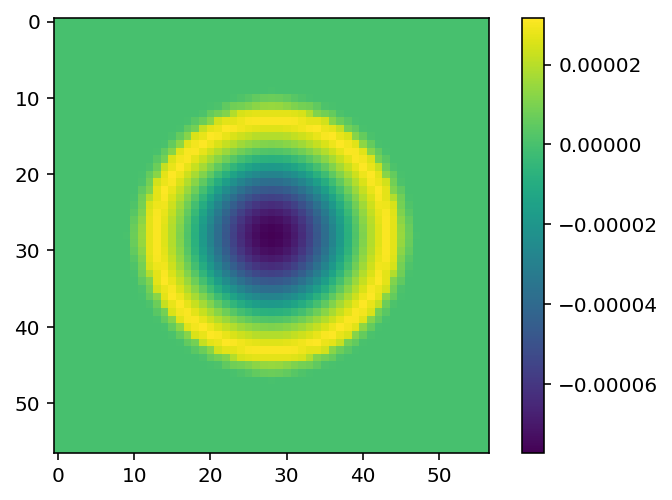

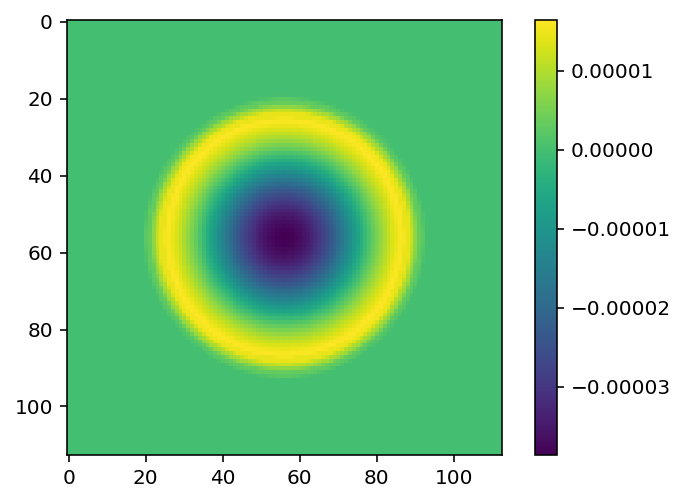

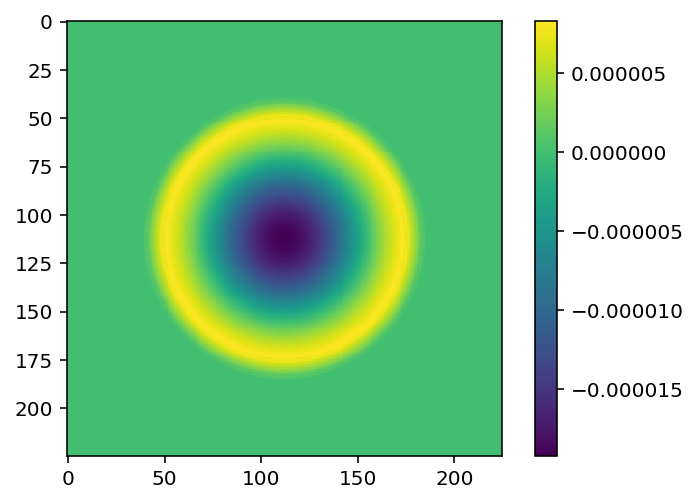

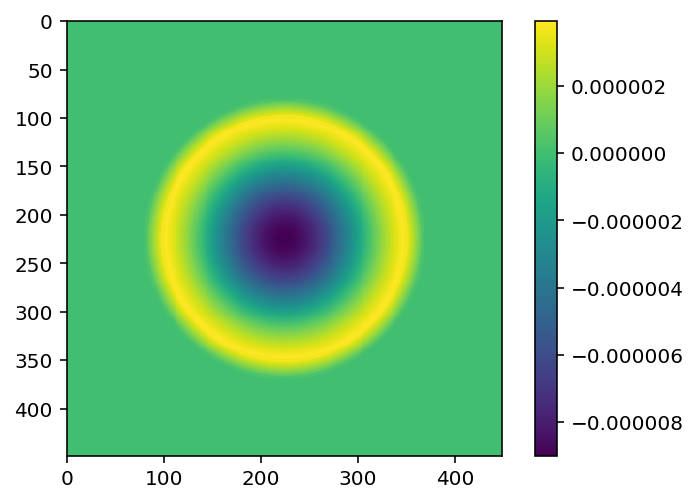

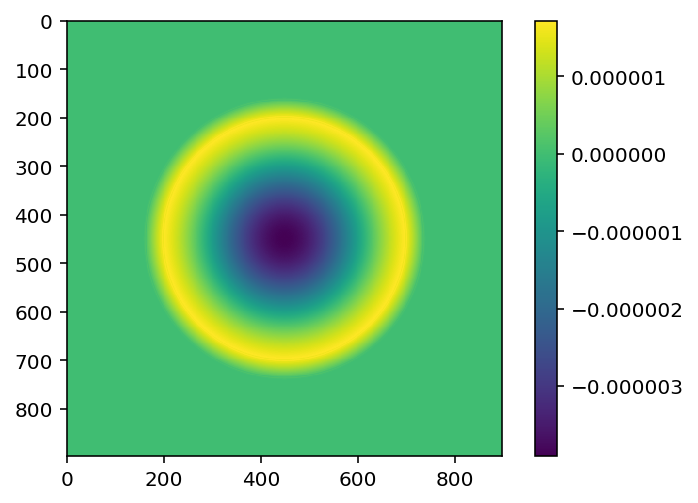

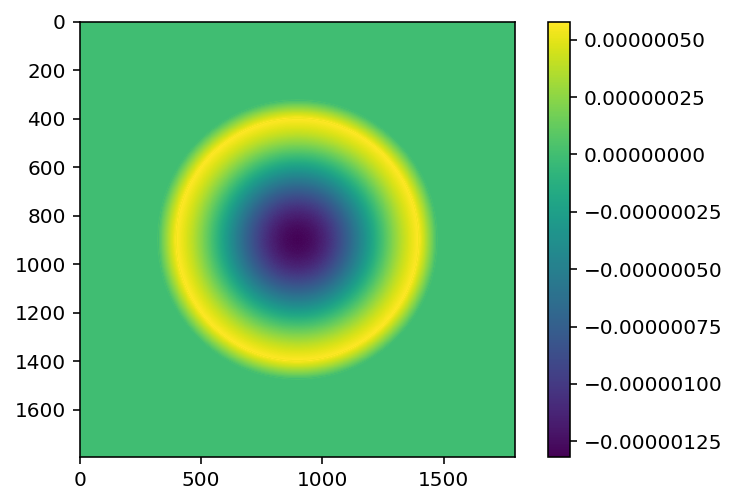

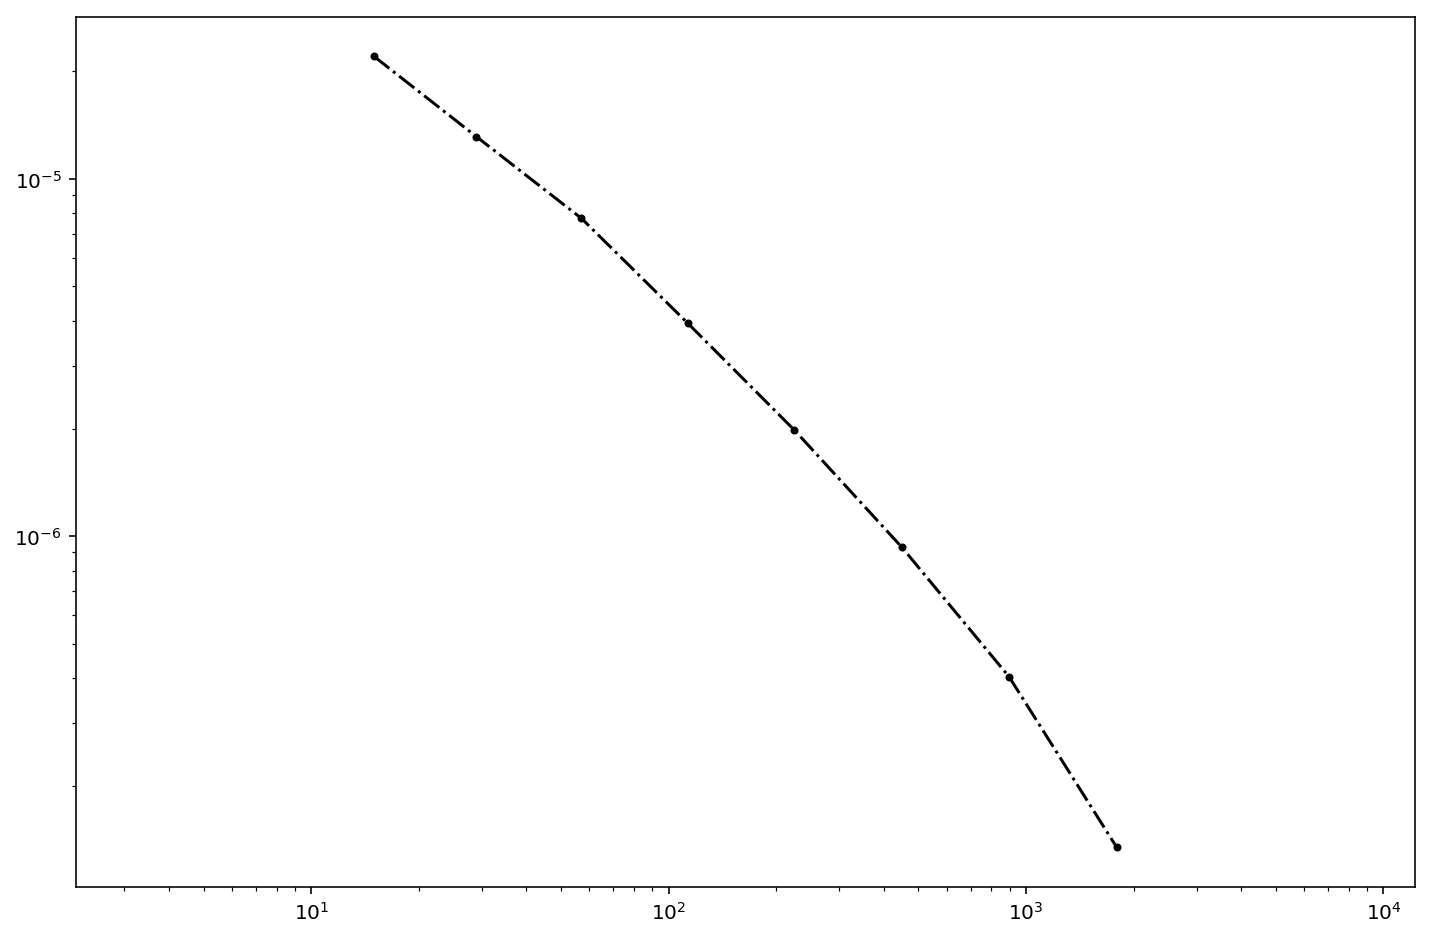

In [10]:
domain_sizes = []
error = []

with np.load(fbl_filename) as npzfile:
    #Get all domain sizes
    domain_sizes = np.array(npzfile.keys(), dtype=np.int)
    error = np.zeros(len(domain_sizes)-1)
    
    #Get largest domain size
    reference_domain_size = np.max(domain_sizes)
    
    #Remove largest from all domain sizes
    domain_sizes = np.delete(domain_sizes, np.where(domain_sizes == reference_domain_size))
    
    #Get reference
    eta1_ref_disk = npzfile[str(reference_domain_size)].astype(np.float64)
    
    #Loop over all other domain sizes
    for l, domain_size in enumerate(domain_sizes):
        #Get simulation
        eta1 = npzfile[str(domain_size)].astype(np.float64)
        
        #Downsample reference to simulation size
        eta1_ref = eta1_ref_disk.copy()
        while (eta1_ref.shape[0] > eta1.shape[0]):
            eta1_ref = eta1_ref[::2,::2]
        
        plt.figure()
        plt.imshow(eta1 - eta1_ref)
        plt.colorbar()
        #eta1_ref_downsampled = eta1_ref[::downsampling, ::downsampling]
        error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=1) / (domain_size*domain_size)
        print(error[l])
        
fig = plt.figure(figsize=(12, 8))
setBwStyles(fig.gca())
plt.loglog(domain_sizes, error)
plt.gca().axis('equal')

## Centered in time, centered in space

In [11]:
def benchmarkCTCS(ctcs_filename):
    
    def runCTCS(domain_size):
        #Clean up old simulator if any:
        if 'ctcs_sim' in globals():
            ctcs_sim.cleanUp()

        nx = domain_size
        ny = domain_size

        dx = float(width/(nx-1))
        dy = float(height/(ny-1))

        ghosts = [1, 1, 1, 1]
        dataShape = (ny + ghosts[1]+ghosts[3], 
                     nx + ghosts[0]+ghosts[2])

        h0 = np.zeros(dataShape, dtype=np.float32);
        eta0 = np.zeros(dataShape, dtype=np.float32);
        hu0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32);
        hv0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32);
        
        max_h_estimate = 0.6
        max_u_estimate = 0.1*np.sqrt(2.0)
        dt = 0.15 * min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))

        initH(h0, ghosts)
        initEtaFD(eta0, ghosts)
        initHU(hu0, ghosts)
        initHV(hv0, ghosts)

        A = 0.0

        #Initialize simulator
        ctcs_sim = CTCS.CTCS(gpu_ctx, \
                      h0, eta0, hu0, hv0, \
                      nx, ny, \
                      dx, dy, dt, \
                      g, f, r, A)

        t = ctcs_sim.step(end_time)
        eta1, hu1, hv1 = ctcs_sim.download()
        print("Domain size={:d}, t={:f}, nt={}, eta=[{:f}, {:f}]".format(domain_size, t, ctcs_sim.num_iterations, np.min(eta1), np.max(eta1)))

        return [eta0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]]
        #return [eta0, hu0, hv0, eta1, hu1, hv1]


    #Run all domain sizes 
    data = {};
    domain_size = int((domain_min)/2)
    for i in range(9):
        domain_size = domain_size*2-1
        [_, _, _, eta1, _, _] = runCTCS(domain_size)
        data[str(domain_size)] = eta1
        #plt.figure()
        #plt.imshow(eta1)

    #Save to file
    np.savez_compressed(ctcs_filename, **data)
    
    
ctcs_filename = imgdir + "/CTCS_data.npz"
benchmarkCTCS(ctcs_filename)

Domain size=15, t=1.000000, nt=3, eta=[0.000000, 0.009762]
Domain size=29, t=1.000000, nt=5, eta=[-0.000000, 0.009735]
Domain size=57, t=1.000000, nt=11, eta=[-0.000000, 0.009725]
Domain size=113, t=1.000000, nt=21, eta=[-0.000000, 0.009723]
Domain size=225, t=1.000000, nt=39, eta=[0.000000, 0.009722]
Domain size=449, t=1.000000, nt=77, eta=[0.000000, 0.009722]
Domain size=897, t=1.000000, nt=155, eta=[0.000000, 0.009722]
Domain size=1793, t=1.000000, nt=307, eta=[0.000000, 0.009722]
Domain size=3585, t=1.000000, nt=615, eta=[0.000000, 0.009722]


5.519174856090103e-06
2.017561552367378e-06
4.605918225996569e-07
1.2085955705232124e-07
2.8297972030101768e-08
6.133286985286126e-09
2.546834196334427e-09
1.0103506623641847e-09


(11.809100198112247,
 2277.4808875192102,
 6.570554612423523e-10,
 8.486805605436704e-06)

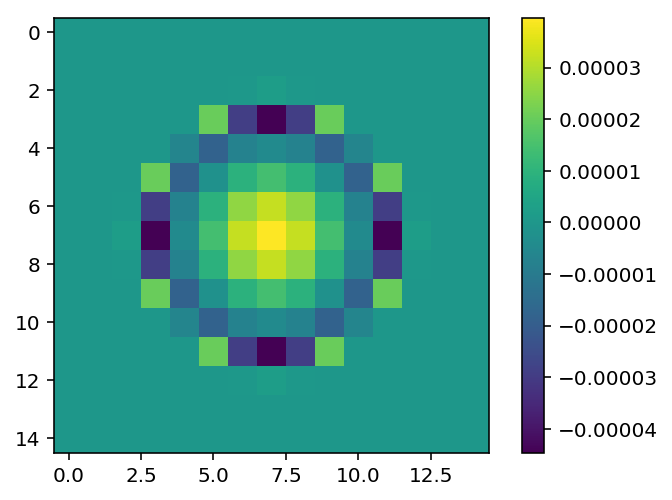

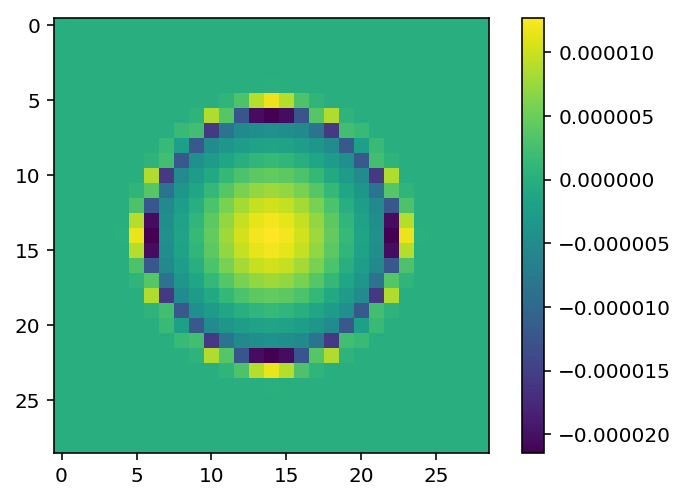

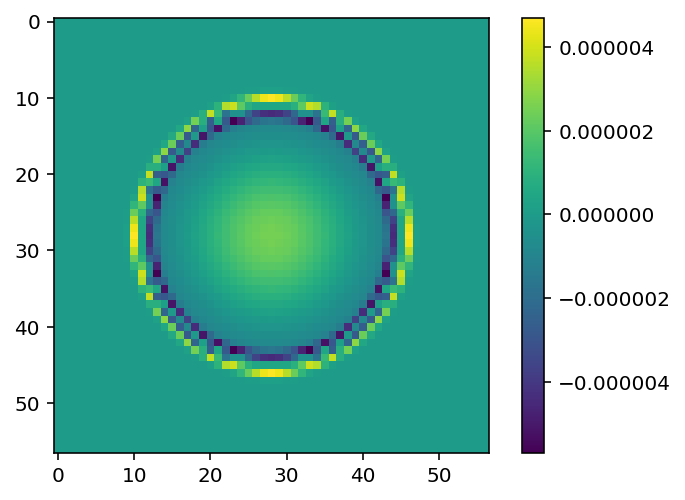

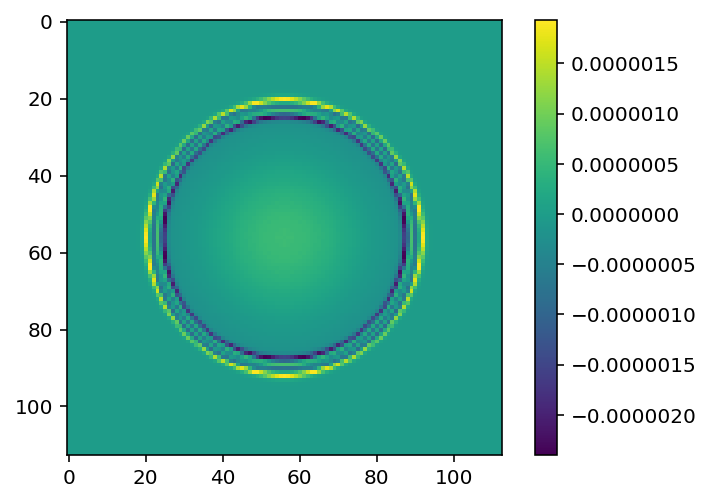

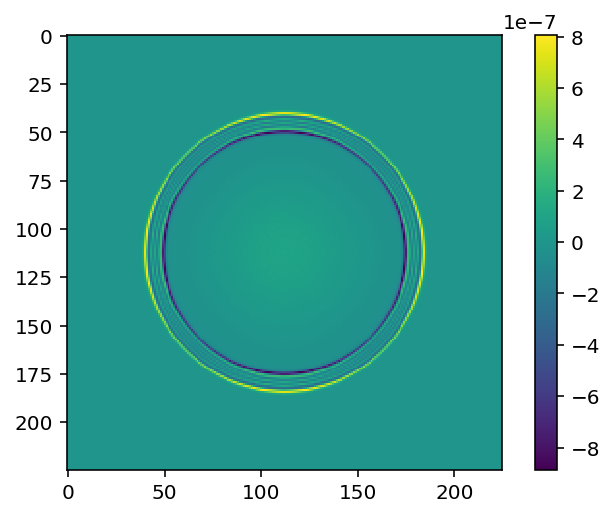

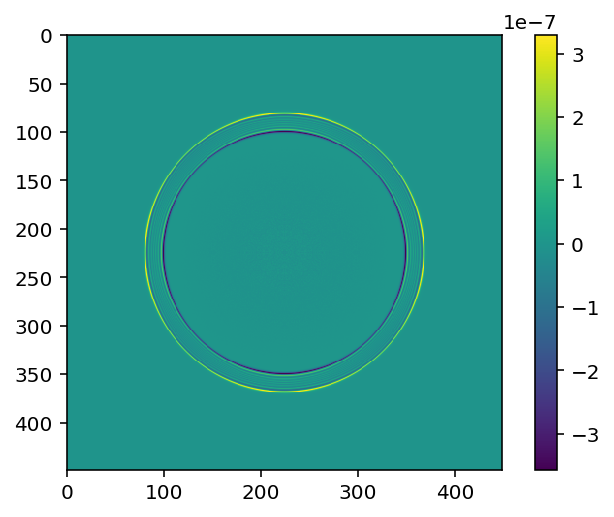

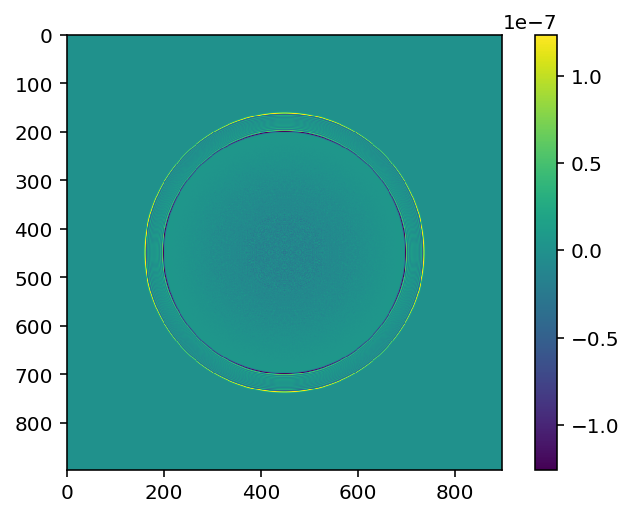

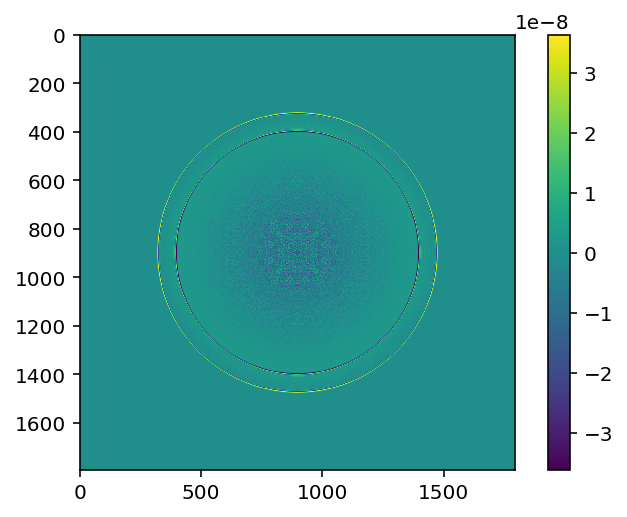

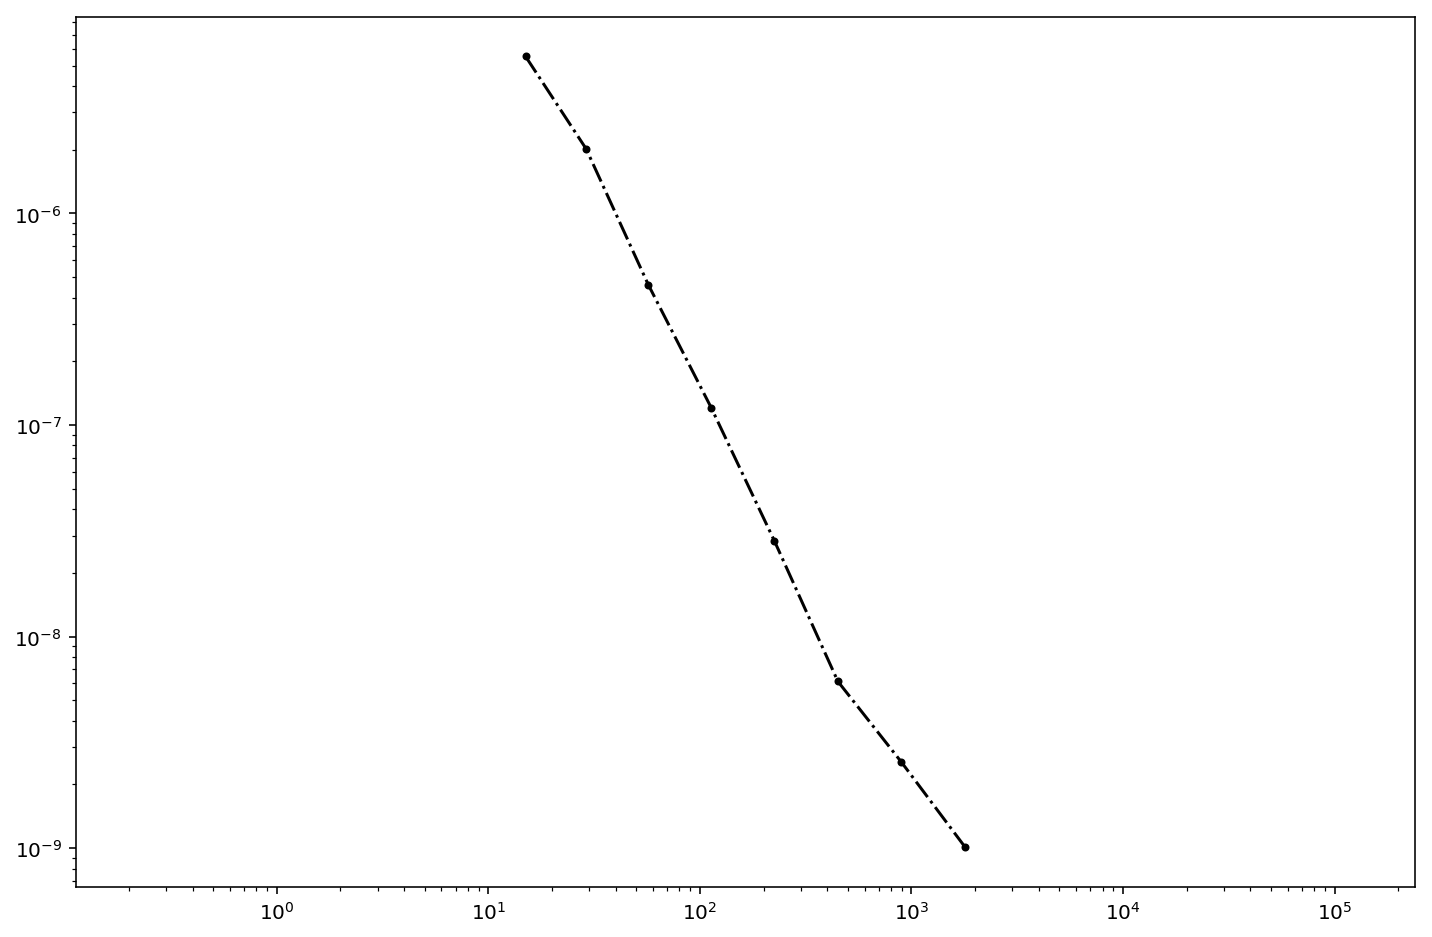

In [12]:
domain_sizes = []
error = []

with np.load(ctcs_filename) as npzfile:
    #Get all domain sizes
    domain_sizes = np.array(npzfile.keys(), dtype=np.int)
    error = np.zeros(len(domain_sizes)-1)
    
    #Get largest domain size
    reference_domain_size = np.max(domain_sizes)
    
    #Remove largest from all domain sizes
    domain_sizes = np.delete(domain_sizes, np.where(domain_sizes == reference_domain_size))
    
    #Get reference
    eta1_ref_disk = npzfile[str(reference_domain_size)].astype(np.float64)
    
    #Loop over all other domain sizes
    for l, domain_size in enumerate(domain_sizes):
        #Get simulation
        eta1 = npzfile[str(domain_size)].astype(np.float64)
        
        #Downsample reference to simulation size
        eta1_ref = eta1_ref_disk.copy()
        while (eta1_ref.shape[0] > eta1.shape[0]):
            eta1_ref = eta1_ref[::2,::2]
        
        plt.figure()
        plt.imshow(eta1 - eta1_ref)
        plt.colorbar()
        #eta1_ref_downsampled = eta1_ref[::downsampling, ::downsampling]
        error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=1) / (domain_size*domain_size)
        print(error[l])
        
fig = plt.figure(figsize=(12, 8))
setBwStyles(fig.gca())
plt.loglog(domain_sizes, error)
plt.gca().axis('equal')

## CDKLM 16

In [13]:
def benchmarkCDKLM(cdklm_filename):
    
    def runCDKLM(domain_size, reference_domain_size):
        #Clean up old simulator if any:
        if 'cdklm_sim' in globals():
            cdklm_sim.cleanUp()

        nx = domain_size
        ny = domain_size

        dx = float(width/nx)
        dy = float(height/ny)

        ghosts = np.array([2,2,2,2])
        dataShape = (ny + ghosts[1]+ghosts[3], 
                     nx + ghosts[0]+ghosts[2])

        Hi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)
        eta0 = np.zeros(dataShape, dtype=np.float32);
        hu0 = np.zeros(dataShape, dtype=np.float32);
        hv0 = np.zeros(dataShape, dtype=np.float32);
        
        max_h_estimate = 0.6
        max_u_estimate = 0.1*np.sqrt(2.0)
        dt = 0.45 * min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))

        initH(Hi, ghosts)
        initEtaFV(eta0, ghosts, reference_domain_size)
        initHU(hu0, ghosts)
        initHV(hv0, ghosts)

        #Initialize simulator
        cdklm_sim = CDKLM16.CDKLM16(gpu_ctx, \
                      eta0, hu0, hv0, Hi, \
                      nx, ny, \
                      dx, dy, dt, \
                      g, f, r)

        t = cdklm_sim.step(end_time)
        eta1, hu1, hv1 = cdklm_sim.download()
        print("Domain size={:d}, t={:f}, nt={}, eta=[{:f}, {:f}]".format(domain_size, t, cdklm_sim.num_iterations, np.min(eta1), np.max(eta1)))

        return [eta0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]]
        #return [eta0, hu0, hv0, eta1, hu1, hv1]


    #Run all domain sizes 
    data = {};
    domain_size = int((domain_min)/2)
    num_levels=7
    reference_domain_size = domain_min*2**num_levels
    for i in range(num_levels+1):
        domain_size = domain_min*2**i
        [_, _, _, eta1, _, _] = runCDKLM(domain_size, reference_domain_size)
        data[str(domain_size)] = eta1

    #Save to file
    np.savez_compressed(cdklm_filename, **data)
    
    
cdklm_filename = imgdir + "/CDKLM_data.npz"
benchmarkCDKLM(cdklm_filename)

Domain size=16, t=1.000000, nt=1, eta=[0.000000, 0.000887]
Domain size=32, t=1.000000, nt=2, eta=[-0.000000, 0.000952]
Domain size=64, t=1.000000, nt=4, eta=[-0.000000, 0.000969]
Domain size=128, t=1.000000, nt=8, eta=[-0.000000, 0.000973]
Domain size=256, t=1.000000, nt=15, eta=[-0.000000, 0.000973]
Domain size=512, t=1.000000, nt=30, eta=[-0.000000, 0.000973]
Domain size=1024, t=1.000000, nt=59, eta=[-0.000000, 0.000973]
Domain size=2048, t=1.000000, nt=117, eta=[-0.000000, 0.000973]


(2048, 2048)
16
1.5293702106460848e-06
32
3.6162125604418366e-07
64
1.1633556468125462e-07
128
3.0553339978153655e-08
256
8.101374587277323e-09
512
7.059604196302379e-09
1024
8.54941181886617e-09


(12.996038341699764,
 1260.6918792651932,
 5.3950284457537275e-09,
 2.001240302129414e-06)

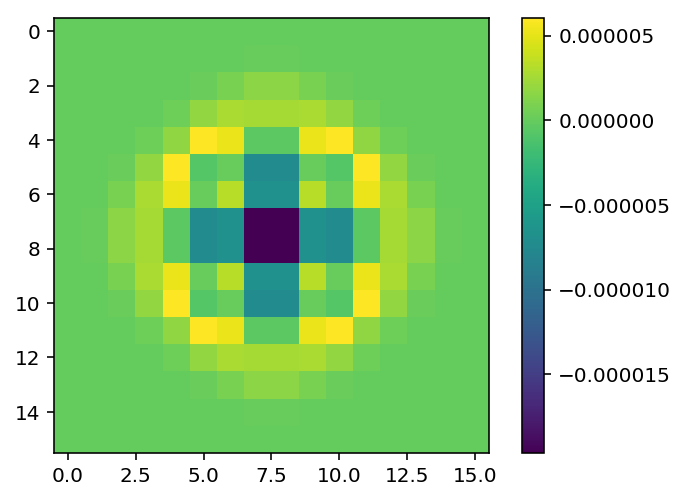

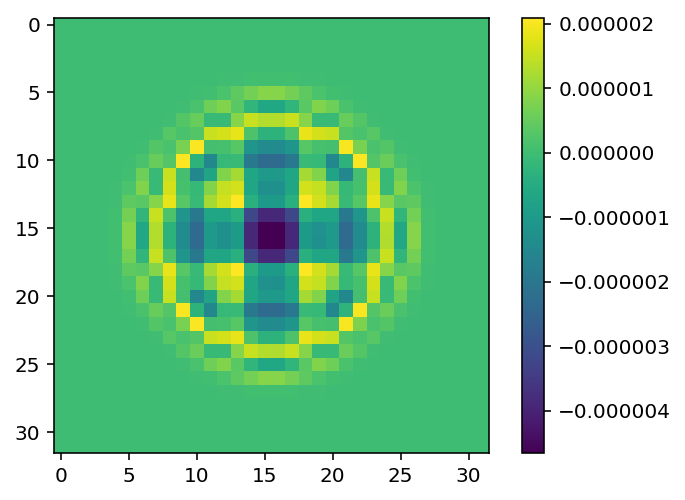

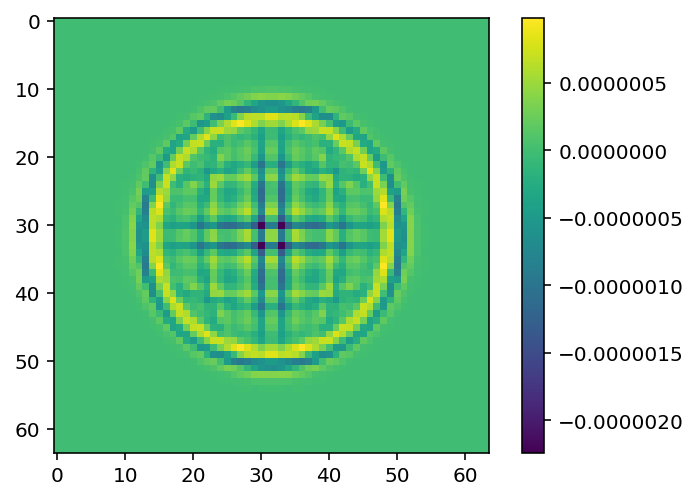

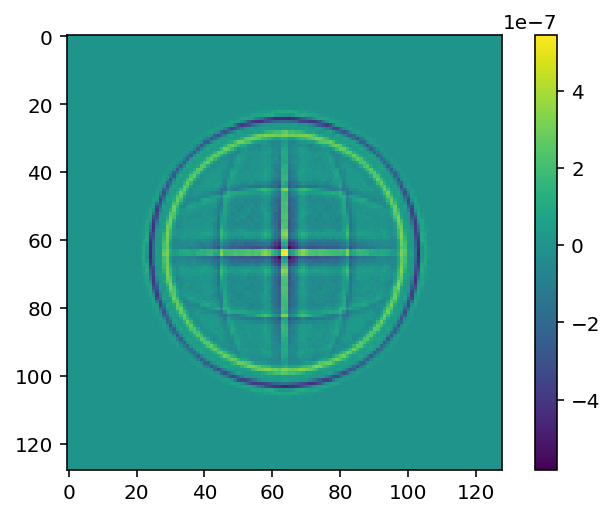

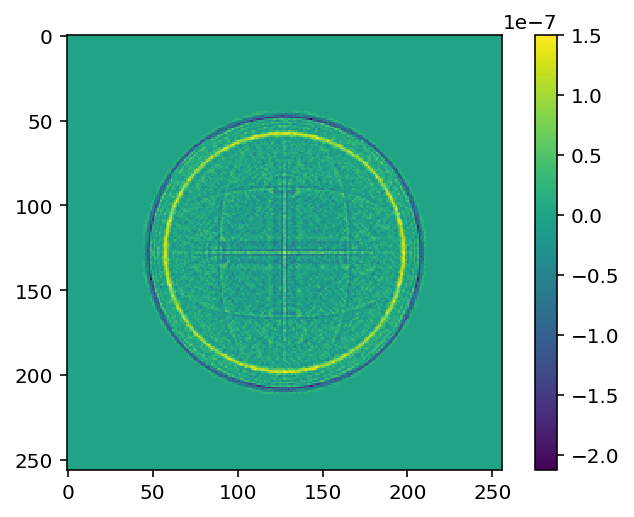

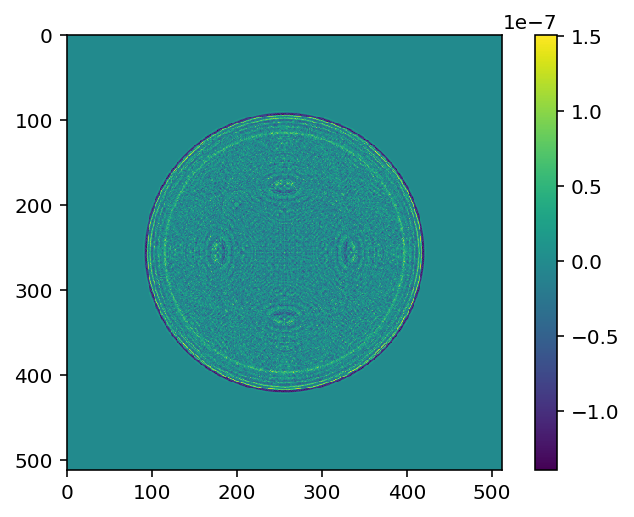

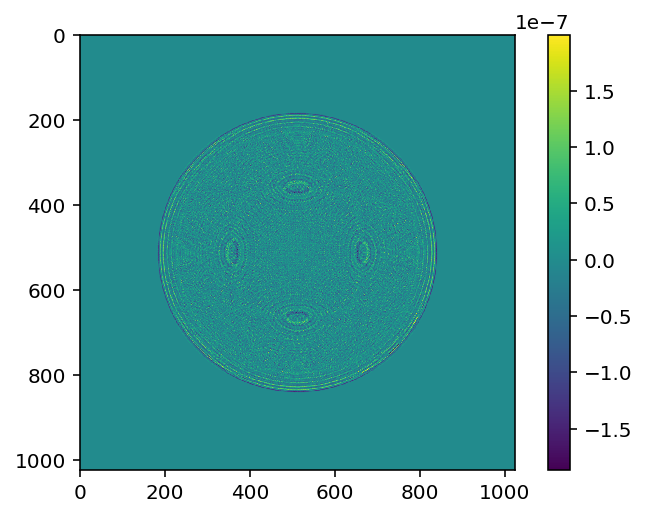

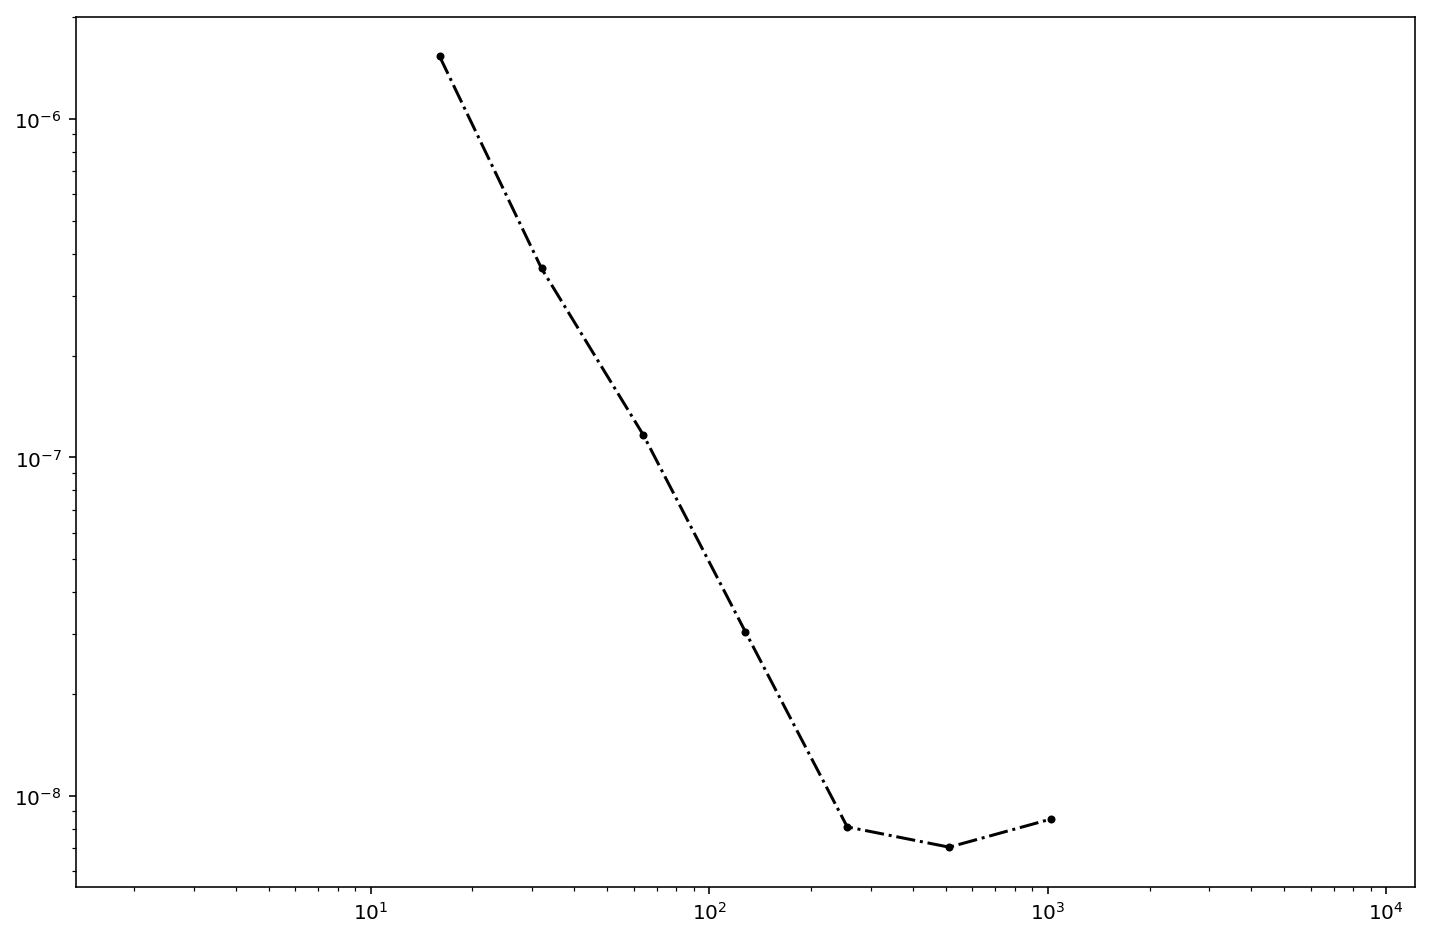

In [14]:
domain_sizes = []
error = []

with np.load(cdklm_filename) as npzfile:
    #Get all domain sizes
    domain_sizes = np.array(npzfile.keys(), dtype=np.int)
    error = np.zeros(len(domain_sizes)-1)
    
    #Get largest domain size
    reference_domain_size = np.max(domain_sizes)
    
    #Remove largest from all domain sizes
    domain_sizes = np.delete(domain_sizes, np.where(domain_sizes == reference_domain_size))
    
    #Get reference
    eta1_ref_disk = npzfile[str(reference_domain_size)].astype(np.float64)
    print(eta1_ref_disk.shape)
    
    #Loop over all other domain sizes
    for l, domain_size in enumerate(domain_sizes):
        #Get simulation
        print(domain_size)
        eta1 = npzfile[str(domain_size)].astype(np.float64)
        
        #Downsample reference to simulation size
        eta1_ref = average(eta1_ref_disk.copy(), reference_domain_size/domain_size)
        
        plt.figure()
        plt.imshow(eta1 - eta1_ref)
        plt.colorbar()
        #eta1_ref_downsampled = eta1_ref[::downsampling, ::downsampling]
        error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=1) / (domain_size*domain_size)
        print(error[l])
        
fig = plt.figure(figsize=(12, 8))
setBwStyles(fig.gca())
plt.loglog(domain_sizes, error)
plt.gca().axis('equal')

## Kurganov-Petrova 2007

In [15]:
def benchmarkKP07(cdklm_filename):
    
    def runKP07(domain_size, reference_domain_size):
        #Clean up old simulator if any:
        if 'kp07_sim' in globals():
            kp07_sim.cleanUp()

        nx = domain_size
        ny = domain_size

        dx = float(width/nx)
        dy = float(height/ny)

        ghosts = np.array([2,2,2,2])
        dataShape = (ny + ghosts[1]+ghosts[3], 
                     nx + ghosts[0]+ghosts[2])

        Hi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)
        eta0 = np.zeros(dataShape, dtype=np.float32);
        hu0 = np.zeros(dataShape, dtype=np.float32);
        hv0 = np.zeros(dataShape, dtype=np.float32);
        
        max_h_estimate = 0.6
        max_u_estimate = 0.1*np.sqrt(2.0)
        dt = 0.45 * min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))

        initH(Hi, ghosts)
        initEtaFV(eta0, ghosts, reference_domain_size)
        initHU(hu0, ghosts)
        initHV(hv0, ghosts)

        #Initialize simulator
        kp07_sim = KP07.KP07(gpu_ctx, \
                      eta0, hu0, hv0, Hi, \
                      nx, ny, \
                      dx, dy, dt, \
                      g, f, r)

        t = kp07_sim.step(end_time)
        eta1, hu1, hv1 = kp07_sim.download()
        print("Domain size={:d}, t={:f}, nt={}, eta=[{:f}, {:f}]".format(domain_size, t, kp07_sim.num_iterations, np.min(eta1), np.max(eta1)))

        return [eta0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]]
        #return [eta0, hu0, hv0, eta1, hu1, hv1]


    #Run all domain sizes 
    data = {};
    domain_size = int((domain_min)/2)
    num_levels=7
    reference_domain_size = domain_min*2**num_levels
    for i in range(num_levels+1):
        domain_size = domain_min*2**i
        [_, _, _, eta1, _, _] = runKP07(domain_size, reference_domain_size)
        data[str(domain_size)] = eta1

    #Save to file
    np.savez_compressed(cdklm_filename, **data)
    
    
kp07_filename = imgdir + "/KP07_data.npz"
benchmarkCDKLM(kp07_filename)

Domain size=16, t=1.000000, nt=1, eta=[0.000000, 0.000887]
Domain size=32, t=1.000000, nt=2, eta=[-0.000000, 0.000952]
Domain size=64, t=1.000000, nt=4, eta=[-0.000000, 0.000969]
Domain size=128, t=1.000000, nt=8, eta=[-0.000000, 0.000973]
Domain size=256, t=1.000000, nt=15, eta=[-0.000000, 0.000973]
Domain size=512, t=1.000000, nt=30, eta=[-0.000000, 0.000973]
Domain size=1024, t=1.000000, nt=59, eta=[-0.000000, 0.000973]
Domain size=2048, t=1.000000, nt=117, eta=[-0.000000, 0.000973]


(2048, 2048)
16
1.5293702106460848e-06
32
3.6162125604418366e-07
64
1.1633556468125462e-07
128
3.0553339978153655e-08
256
8.101374587277323e-09
512
7.059604196302379e-09
1024
8.54941181886617e-09


(12.996038341699764,
 1260.6918792651932,
 5.3950284457537275e-09,
 2.001240302129414e-06)

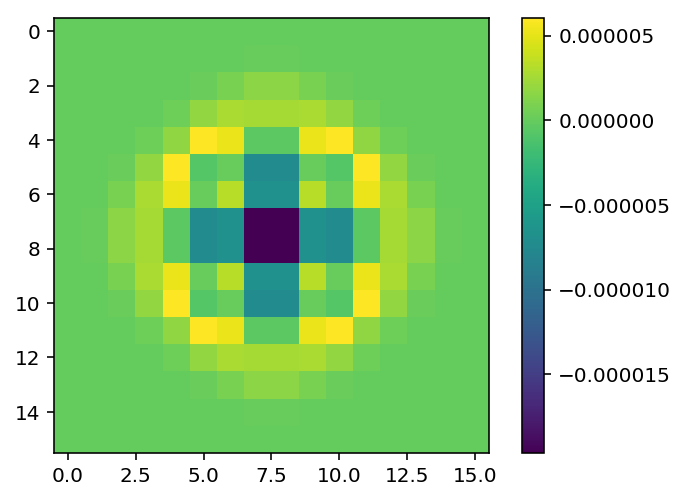

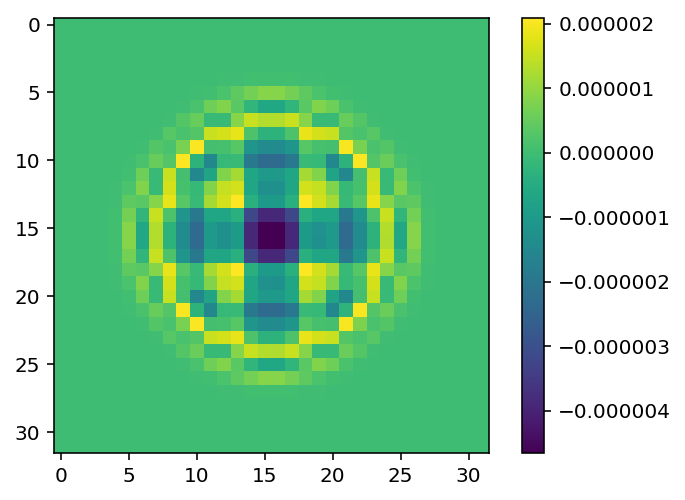

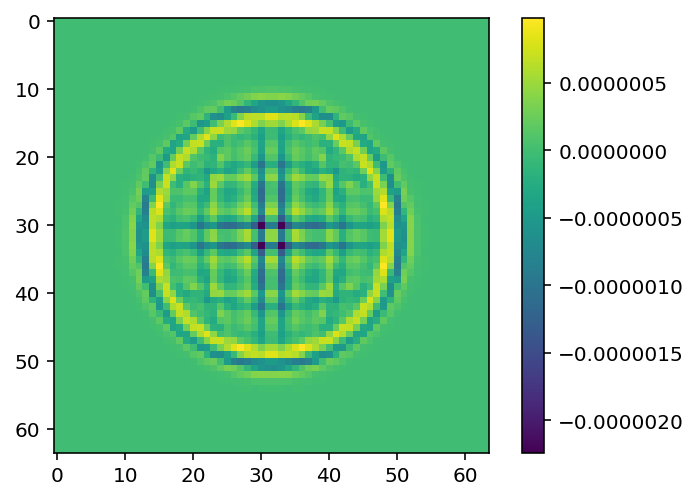

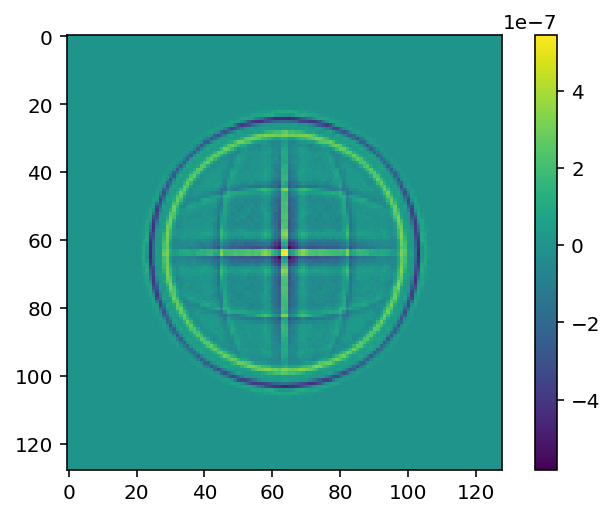

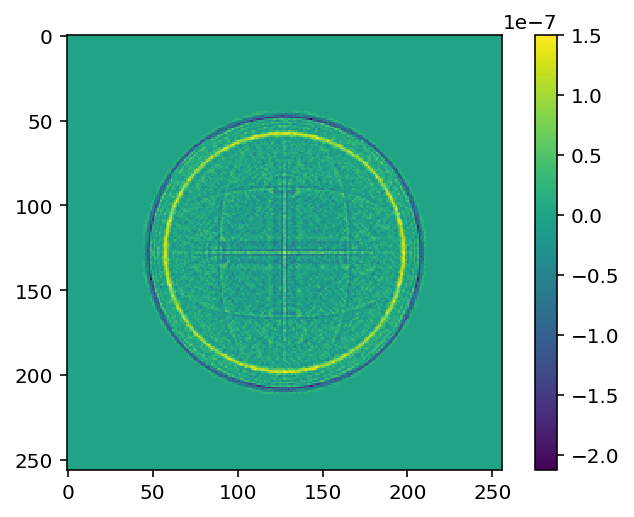

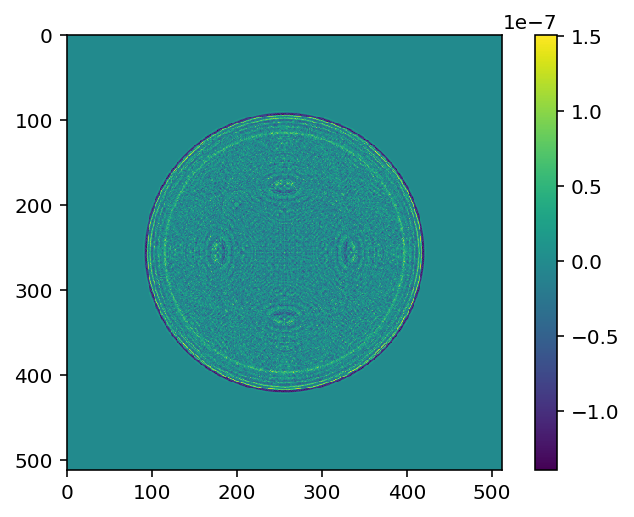

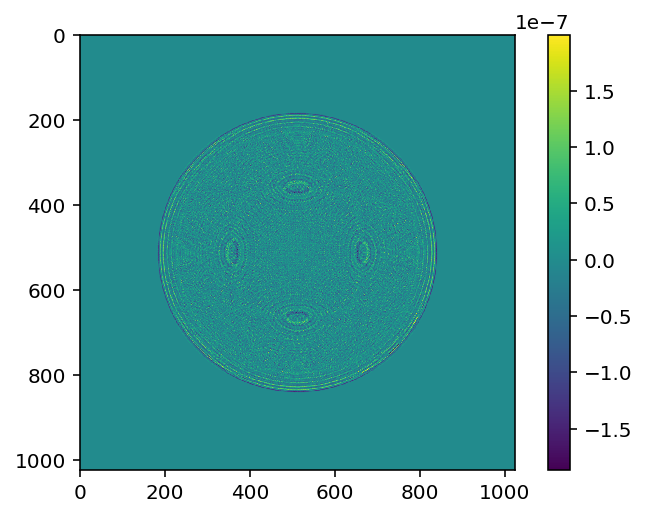

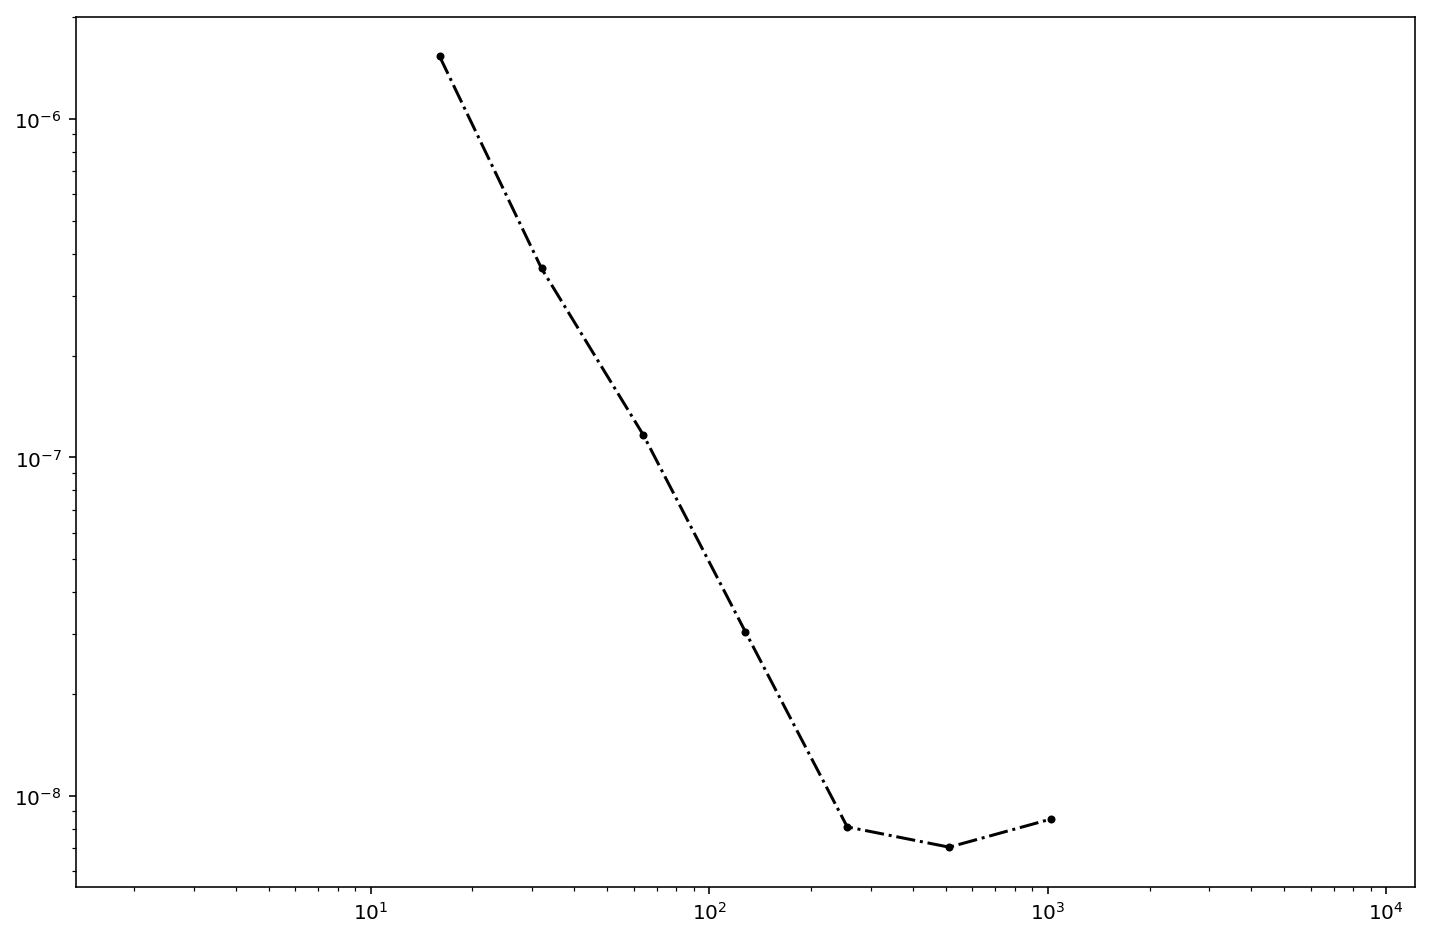

In [16]:
domain_sizes = []
error = []

with np.load(kp07_filename) as npzfile:
    #Get all domain sizes
    domain_sizes = np.array(npzfile.keys(), dtype=np.int)
    error = np.zeros(len(domain_sizes)-1)
    
    #Get largest domain size
    reference_domain_size = np.max(domain_sizes)
    
    #Remove largest from all domain sizes
    domain_sizes = np.delete(domain_sizes, np.where(domain_sizes == reference_domain_size))
    
    #Get reference
    eta1_ref_disk = npzfile[str(reference_domain_size)].astype(np.float64)
    print(eta1_ref_disk.shape)
    
    #Loop over all other domain sizes
    for l, domain_size in enumerate(domain_sizes):
        #Get simulation
        print(domain_size)
        eta1 = npzfile[str(domain_size)].astype(np.float64)
        
        #Downsample reference to simulation size
        eta1_ref = average(eta1_ref_disk.copy(), reference_domain_size/domain_size)
        
        plt.figure()
        plt.imshow(eta1 - eta1_ref)
        plt.colorbar()
        #eta1_ref_downsampled = eta1_ref[::downsampling, ::downsampling]
        error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=1) / (domain_size*domain_size)
        print(error[l])
        
fig = plt.figure(figsize=(12, 8))
setBwStyles(fig.gca())
plt.loglog(domain_sizes, error)
plt.gca().axis('equal')